In [1]:
import torch
import torch.nn as nn
from torch.utils.data import  Dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertModel
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import ast
import datetime as dt
import gc

from sklearn.decomposition import PCA
import plotly.express as px

C:\Users\y3g9r\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Обучение модели

In [2]:
class DisambiguationDataset(Dataset):
    def __init__(self, samples,labels):
        self.samples = samples
        self.labels = labels
        self.len = len(self.samples)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        items = {"text_input_ids": torch.tensor(self.samples[index][0]),
                 "text_input_mask": torch.tensor(self.samples[index][1]),
                 "text_segment_ids": torch.tensor(self.samples[index][2]),
                 "text_offset_mapping": torch.tensor(self.samples[index][3]),
                 "text_pos": torch.tensor(self.samples[index][4]),
                 "def_input_ids": torch.tensor(self.samples[index][5]),
                 "def_input_mask": torch.tensor(self.samples[index][6]),
                 "def_segment_ids": torch.tensor(self.samples[index][7]),
                 "label": torch.tensor(self.labels[index])}
        return items

In [3]:
class BertVectors():
    def __init__(self, device='cuda:0'):
        self.device = device
        self.bert = BertModel.from_pretrained('sberbank-ai/sbert_large_mt_nlu_ru', output_hidden_states=True,
                                              return_dict=False).to(self.device)
        
        for layer in self.bert.encoder.layer[:20]:
            for param in layer.parameters():
                param.requires_grad = False
                

    def forward(self, text_input_ids, text_input_mask, text_segment_ids, text_offset_mapping,
                text_pos, def_input_ids, def_input_mask, def_segment_ids):

        embd_batch = torch.tensor([[[], []]]).to(self.device)
        first_pass = False
        for i in range(len(text_input_ids)):
            # получаем эмбединги ключевого слова из примера употребления
            examples_token_key_word_position = self.token_detection(text_offset_mapping[i], text_pos[i][0])
            example_token_vec = self.get_vector(text_input_ids[i], text_segment_ids[i], text_input_mask[i])
            example_embeddings = self.vector_recognition(example_token_vec, examples_token_key_word_position)

            # получаем эмбединг определения
            def_embedding = self.get_defenition_embedding(def_input_ids[i], def_segment_ids[i],
                                                          def_input_mask[i]).squeeze(0)
            # объединяем два вектора в 1 и добавляем в общий массив (получаем тензор 2x768)
            embd_sample = torch.stack((example_embeddings, def_embedding)).to(self.device)
            if not first_pass:
                embd_batch = torch.cat((embd_batch, embd_sample.unsqueeze(0)), -1)
                first_pass = True
            else:
                embd_batch = torch.cat((embd_batch, embd_sample.unsqueeze(0)), 0)

                
        text_emb = embd_batch[:, 0, :]
        def_emb = embd_batch[:, 1, :]
        
        return text_emb, def_emb



    def get_defenition_embedding(self, def_input_ids, def_segment_ids, def_input_mask):
        """
        Функция получения вектора дефенишина сущности
        :param def_input_ids:
        :param def_segment_ids:
        :param def_input_mask:
        :return: bert pooler output vector
        """
        with torch.no_grad():
            output = self.bert(input_ids=def_input_ids.unsqueeze(0), token_type_ids=def_segment_ids.unsqueeze(0),
                               attention_mask=def_input_mask.unsqueeze(0))
        hidden_states = output[1]
        return hidden_states

    def token_detection(self, token_map, position):
        """
        Функция определения ключевого слова
        :param token_map: list of tuples of begin and end of every token
        :param position:  list of type: [int,int]
        :return: list of key word tokens position
        """
        # из за того что в начале стоит CLS позиции начала и конца ключевого слова сдвигаются на 5
        begin_postion = position[0]  # + 5
        end_position = position[1]  # + 5

        position_of_key_tokens = []
        for token_tuple in range(1, len(token_map) - 1):
            # Если ключевое слово представляется одним токеном
            if token_map[token_tuple][0] == begin_postion and token_map[token_tuple][1] == end_position:
                position_of_key_tokens.append(token_tuple)
                break

            # Если ключевое слово представляется несколькими токенами
            if token_map[token_tuple][0] >= begin_postion and token_map[token_tuple][1] != end_position:
                position_of_key_tokens.append(token_tuple)
            if token_map[token_tuple][0] != begin_postion and token_map[token_tuple][1] == end_position:
                position_of_key_tokens.append(token_tuple)
                break

        return position_of_key_tokens

    def get_vector(self, input_ids_samp, token_type_ids_samp, attention_mask_samp):
        """
        Функция получения вектора ключевого слова
        :param input_ids_samp:
        :param token_type_ids_samp:
        :param attention_mask_samp:
        :return:
        """
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids_samp.unsqueeze(0), token_type_ids=token_type_ids_samp.unsqueeze(0),
                                attention_mask=attention_mask_samp.unsqueeze(0))
        hidden_states = outputs[2]

        # из [# layers, # batches, # tokens, # features]
        # в [# tokens, # layers, # features]
        token_dim = torch.stack(hidden_states, dim=0)
        token_dim = torch.squeeze(token_dim, dim=1)
        token_dim = token_dim.permute(1, 0, 2)
        token_vecs_cat = []
        for token in token_dim:
            cat_vec = torch.sum(token[-4:], dim=0)
            token_vecs_cat.append(cat_vec)
        return token_vecs_cat


    def vector_recognition(self, tokens_embeddings_ex, tokens_key_word_position_ex):
        """
        Функция подготовки вектора в зависимости от количества токенов,которым представляется ключевое слово
        :param tokens_embeddings_ex:
        :param tokens_key_word_position_ex:
        :return:
        """
        if len(tokens_key_word_position_ex) > 1:
            embeddings_data = torch.tensor(
                self.__get_avarage_embedding(tokens_embeddings_ex, tokens_key_word_position_ex))
        else:
            embeddings_data = torch.tensor(tokens_embeddings_ex[tokens_key_word_position_ex[0]])
        return embeddings_data

    def __get_avarage_embedding(self, embeddings_list, positions_list):
        """
        Функция получения среднего вектора (применяется в случае если ключевое слово состоит из нескольких токенов)
        :param embeddings_list:
        :param positions_list:
        :return:
        """
        avg_tensor = torch.stack((embeddings_list[positions_list[0]],))
        for i in range(1, len(positions_list)):
            avg_tensor = torch.cat((avg_tensor, embeddings_list[positions_list[i]].unsqueeze(0)))

        average_embedding = torch.mean(avg_tensor, 0)
        return average_embedding

In [4]:
def data_preparation(texts, definitions, position, labels, tokenizer, max_len):
    tokenizer = tokenizer
    feautures_X, feautures_Y = [], []

    for i, (text, definition) in enumerate(zip(texts, definitions)):
        text = tokenizer(text, return_offsets_mapping=True,max_length=max_len,truncation=True,padding='max_length')

        text_input_ids = text["input_ids"]
        text_input_mask = text["attention_mask"]
        text_segment_ids = text["token_type_ids"]
        text_offset_mapping = text["offset_mapping"]
        text_pos = [position[i]]

        definition = tokenizer(definition, return_offsets_mapping=True,max_length=max_len,padding='max_length',truncation=True)

        def_input_ids = definition["input_ids"]
        def_input_mask = definition["attention_mask"]
        def_segment_ids = definition["token_type_ids"]

        feautures_X.append([text_input_ids, text_input_mask, text_segment_ids, text_offset_mapping,
                            text_pos, def_input_ids, def_input_mask, def_segment_ids])
        feautures_Y.append(labels[i])

    return feautures_X, feautures_Y

C:\Users\y3g9r\AppData\Local\Temp\ipykernel_24264\2307715024.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_data = torch.tensor(tokens_embeddings_ex[tokens_key_word_position_ex[0]])
C:\Users\y3g9r\AppData\Local\Temp\ipykernel_24264\2307715024.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_data = torch.tensor(
C:\Users\y3g9r\AppData\Local\Temp\ipykernel_24264\2648227372.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


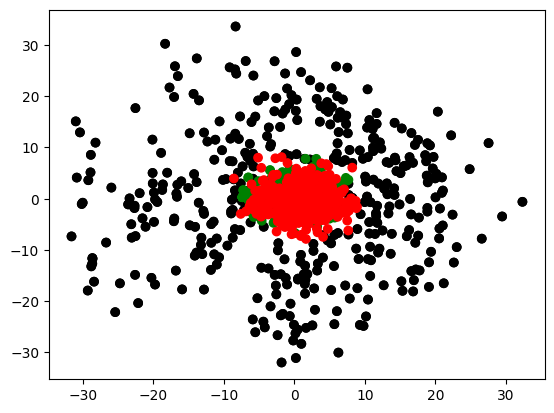

In [5]:
df = pd.read_csv('../../nn_data.csv')
df.position = df.position.apply(lambda x: ast.literal_eval(x))

max_len_text = df.text.str.len().max()
max_len_def = df.definition.str.len().max()

max_len = max_len_def
if max_len_text > max_len_def:
    max_len = max_len_text

data_X, data_Y = data_preparation(df.text,
                                  df.definition,
                                  df.position,
                                  df.label,
                                  BertTokenizerFast.from_pretrained('sberbank-ai/sbert_large_mt_nlu_ru',
                                                                do_lower_case=True),
                                  max_len)

dataset = DisambiguationDataset(data_X[:800], data_Y[:800])
loader = DataLoader(dataset=dataset, batch_size=800,shuffle=False, drop_last=True)
bv = BertVectors("cuda:0")

vect_dict = {"text":[], "def":[], "label": []}


device="cuda:0"
for i,batch in enumerate(loader):
    target = batch["label"].float().to(device)
    text_input_ids = batch["text_input_ids"].to(device)
    text_input_mask = batch["text_input_mask"].to(device)
    text_segment_ids = batch["text_segment_ids"].to(device)
    text_offset_mapping = batch["text_offset_mapping"].to(device)
    text_pos = batch["text_pos"].to(device)
    def_input_ids = batch["def_input_ids"].to(device)
    def_input_mask = batch["def_input_mask"].to(device)
    def_segment_ids = batch["def_segment_ids"].to(device)


    x1,x2 = bv.forward(text_input_ids, text_input_mask, text_segment_ids, text_offset_mapping,
               text_pos, def_input_ids, def_input_mask, def_segment_ids)
    
    vect_dict["text"].append(x1.detach().cpu().numpy())
    vect_dict["def"].append(x2.detach().cpu().numpy())
    vect_dict["label"].append(target.detach().cpu().numpy())
    
    vect_dict["text"] = vect_dict["text"][0]
    vect_dict["def"] = vect_dict["def"][0]
    vect_dict["label"] = vect_dict["label"][0]

    pca = PCA(n_components=2, random_state=42)
    text_2d = pd.DataFrame(pca.fit_transform(vect_dict["text"]), columns=['x1', 'x2'])
    text_2d['label'] = 'black'
    
    def_2d = pd.DataFrame(pca.fit_transform(vect_dict["def"]), columns=['x1', 'x2'])
    def_2d['label'] = vect_dict["label"]
    
    def_p_2d = pd.DataFrame(def_2d[def_2d['label']==1], columns=['x1', 'x2'])
    def_p_2d['label'] = 'green'
    
    def_n_2d = pd.DataFrame(def_2d[def_2d['label']==0], columns=['x1', 'x2'])
    def_n_2d['label'] = 'red'
    
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(x=text_2d['x1'], y=text_2d['x2'], color=text_2d['label'],label = "text")
    ax1.scatter(x=def_p_2d['x1'], y=def_p_2d['x2'], color=def_p_2d['label'], label = "def_p")
    ax1.scatter(x=def_n_2d['x1'], y=def_n_2d['x2'], color=def_n_2d['label'], label = "def_n")
    fig.show()


In [6]:
df = pd.DataFrame({'x':[1,2,3,4,5],'y':[1,0,1,1,0]})

In [7]:
df1=df[df['y']==1]
df1

,x,y
0,1,1
2,3,1
3,4,1
